## Resnet using Keras

In [ ]:
## Import Libraries in this block ##
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
import numpy as np

from keras import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.models import Model
from keras.datasets import cifar10
from keras.utils import plot_model
from keras.utils import to_categorical
import numpy as np
from PIL import Image 
import os

from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, concatenate
from tensorflow.keras.models import Model
from keras.applications import ResNet50
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import sys
import os
prefix = '/content/gdrive/My Drive/'
customized_path = 'DeepLearning'
sys_path = os.path.join(prefix, customized_path)
sys.path.append(sys_path)
%cd /content/gdrive/MyDrive/DeepLearning
!ls

/content/gdrive/MyDrive/DeepLearning
best_model_c10.h5	   c10_resnet20_model.103.h5  resnet.png
best_resnet_model_c100.h5  cat.png		      saved_models
best_resnet_model_c10.h5   cnn-y-network.png


In [ ]:
## Funtion to load and normalize data ##

def load_datset(dataset):
  if dataset == "cifar10":
    cifar10 = tf.keras.datasets.cifar10
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    
  elif dataset == "cifar100":
    cifar100 = tf.keras.datasets.cifar100
    (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

  
  x_train = x_train.astype('float32') / 255
  x_test = x_test.astype('float32') / 255

  print("Train Data shape for {}:{}{}".format(dataset,x_train.shape, y_train.shape))
  print("Test Data shape for {}:{}{}".format(dataset,x_test.shape, y_test.shape))

  return x_train, x_test,y_train,y_test

In [ ]:
##Learning Rate Schedule ##
def lr_schedule(epoch):

    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [ ]:
## Funtion to train , test and plot training curve ##

def train_test_plot(model, x_train,y_train,x_val,y_val,x_test,y_test, optimizer,epochs,batch_size):
  
  
  # Compile model

  model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
  
  # prepare model model saving directory.
  save_dir = os.path.join(os.getcwd(), 'saved_models')
  model_name = 'c10_resnet20_model.{epoch:03d}.h5' 
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  filepath = os.path.join(save_dir, model_name)

  # prepare callbacks for model saving and for learning rate adjustment.
  
  steps_per_epoch=len(x_train)//batch_size
  save_period = 20
  checkpoint = ModelCheckpoint(filepath=filepath,
                               monitor='val_acc',
                               verbose=1,
                               save_freq=int(steps_per_epoch*save_period))

  lr_scheduler = LearningRateScheduler(lr_schedule)

  lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

  callbacks = [checkpoint, lr_reducer, lr_scheduler]
  
  #augmented data
  datagen = ImageDataGenerator(
      # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False
      )
  datagen.fit(x_train)
  # Train the model 
  history= model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_val,y_val),
                        epochs=epochs, verbose=1, workers=4,
                        steps_per_epoch=len(x_train)//batch_size,
                        callbacks=callbacks)
 

  # Evaluate Model on Test set
  score = model.evaluate(x_test,
                       y_test,
                       batch_size=batch_size,
                       verbose=2)
  print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))
  
  #Plot training curve
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [ ]:
## Funtion to build Resnet ##
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes):


    # Start model definition.
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model



In [ ]:
#Load both datasets
#CIFAR10 
x_train, x_test,y_train,y_test = load_datset("cifar10")
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

# From sparse label to categorical
num_labels = len(np.unique(y_train))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print("Number of unique classes:",num_labels)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=1)

#CIFAR100
x_train_100, x_test_100,y_train_100,y_test_100 = load_datset("cifar100")

num_labels_100 = len(np.unique(y_train_100))
y_train_100 = to_categorical(y_train_100)
y_test_100 = to_categorical(y_test_100)
print("Number of unique classes:",num_labels_100)

x_train_100, x_val_100, y_train_100, y_val_100 = train_test_split(x_train_100, y_train_100, test_size = 0.1, random_state=1)

Train Data shape for cifar10:(50000, 32, 32, 3)(50000, 1)
Test Data shape for cifar10:(10000, 32, 32, 3)(10000, 1)
Number of unique classes: 10
Train Data shape for cifar100:(50000, 32, 32, 3)(50000, 1)
Test Data shape for cifar100:(10000, 32, 32, 3)(10000, 1)
Number of unique classes: 100


In [108]:
#Cifar10
## Network parameters
batch_size = 32
n_filters =16
## No of residual blocks(depth=20 => n=3) ##
n=5
## d = 6n+2 ##
depth = n*6+2

model=resnet_v1(input_shape,depth,num_labels)

# verify the model using graph
# enable this if pydot can be installed
#!pip install pydot
#plot_model(model, to_file='resnet.png', show_shapes=True)
model.summary()



Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_55[0][0]                   
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization_23[0][0]     
___________________________________________________________________________________________

Learning rate:  0.001


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
Learning rate:  0.001
1250/1250 [==============================] - 40s 29ms/step - loss: 1.9527 - accuracy: 0.3838 - val_loss: 1.8036 - val_accuracy: 0.5058
Epoch 2/200
Learning rate:  0.001
1250/1250 [==============================] - 35s 28ms/step - loss: 1.3747 - accuracy: 0.5926 - val_loss: 1.3687 - val_accuracy: 0.6097
Epoch 3/200
Learning rate:  0.001
1250/1250 [==============================] - 35s 28ms/step - loss: 1.1598 - accuracy: 0.6658 - val_loss: 1.4445 - val_accuracy: 0.6254
Epoch 4/200
Learning rate:  0.001
1250/1250 [==============================] - 35s 28ms/step - loss: 1.0538 - accuracy: 0.7090 - val_loss: 1.3842 - val_accuracy: 0.6259
Epoch 5/200
Learning rate:  0.001
1250/1250 [==============================] - 35s 28ms/step - loss: 0.9710 - accuracy: 0.7418 - val_loss: 1.1352 - val_accuracy: 0.7013
Epoch 6/200
Learning rate:  0.001
1250/1250 [==============================] - 35s 28ms/step - loss: 0.9090 - accuracy: 0.7605 - val_loss: 1.0898 - val_acc

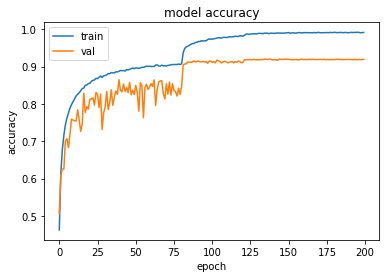

In [ ]:
## CIFAR10
## Training parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs = 200

train_test_plot(model,x_train,y_train,x_val,y_val,x_test,y_test,optimizer,epochs,batch_size)


In [ ]:
model.save('best_resnet_model_c10.h5')

In [ ]:
##use if you have saved model(remeber to change path in earlier sections to point to the saved model)
##Load saved model and check accuracy
#!ls
model = tf.keras.models.load_model('best_resnet_model_c10.h5')
#new_model.summary()
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

best_model_c10.h5	   cat.png	      saved_models
best_resnet_model_c100.h5  cnn-y-network.png
best_resnet_model_c10.h5   resnet.png
313/313 - 2s - loss: 0.5144 - accuracy: 0.9096
Restored model, accuracy: 90.96%


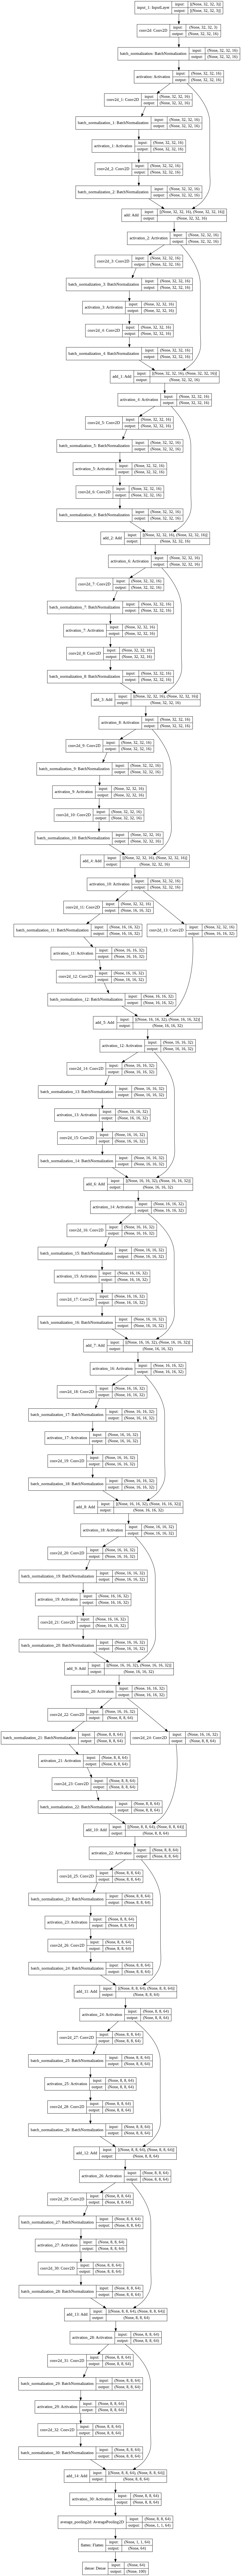

In [ ]:
#Cifar100
## Network parameters
batch_size = 32
n_filters =16
## No of residual blocks(depth=20 => n=3) ##
n=5
## d = 6n+2 ##
depth = n*6+2

model_100=resnet_v1(input_shape,depth,num_labels_100)

# verify the model using graph
# enable this if pydot can be installed
#!pip install pydot
plot_model(model_100, to_file='resnet.png', show_shapes=True)

Learning rate:  0.001


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
Learning rate:  0.001
1406/1406 [==============================] - 51s 22ms/step - loss: 4.7059 - accuracy: 0.0521 - val_loss: 4.1726 - val_accuracy: 0.1038
Epoch 2/200
Learning rate:  0.001
1406/1406 [==============================] - 30s 22ms/step - loss: 3.6893 - accuracy: 0.1674 - val_loss: 3.4399 - val_accuracy: 0.2102
Epoch 3/200
Learning rate:  0.001
1406/1406 [==============================] - 30s 21ms/step - loss: 3.2525 - accuracy: 0.2437 - val_loss: 3.3412 - val_accuracy: 0.2482
Epoch 4/200
Learning rate:  0.001
1406/1406 [==============================] - 30s 21ms/step - loss: 2.9293 - accuracy: 0.3098 - val_loss: 3.0341 - val_accuracy: 0.3020
Epoch 5/200
Learning rate:  0.001
1406/1406 [==============================] - 30s 21ms/step - loss: 2.7036 - accuracy: 0.3611 - val_loss: 3.0187 - val_accuracy: 0.3220
Epoch 6/200
Learning rate:  0.001
1406/1406 [==============================] - 30s 22ms/step - loss: 2.5436 - accuracy: 0.3933 - val_loss: 2.7202 - val_acc

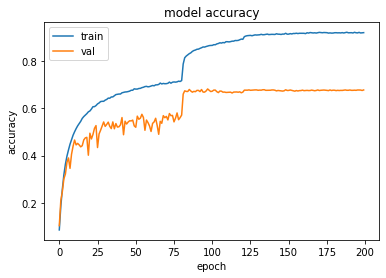

In [ ]:
## CIFAR100
## Training parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs = 200

train_test_plot(model_100, x_train_100, y_train_100, x_val_100, y_val_100, x_test_100, y_test_100, optimizer, epochs, batch_size)
model_100.save('best_resnet_model_c100.h5')


In [ ]:
##use if you have saved model(remeber to change path in earlier sections to point to the saved model)
##Load saved model and check accuracy
#!ls
model_100 = tf.keras.models.load_model('best_resnet_model_c100.h5')
#new_model.summary()
loss, acc = model_100.evaluate(x_test_100, y_test_100, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

313/313 - 2s - loss: 1.6995 - accuracy: 0.6837
Restored model, accuracy: 68.37%


#***Transfer Learning***

In [ ]:
## Import Pretrained resnet50 model using keras ##
base_model_2 = ResNet50(include_top=False,weights='imagenet',input_shape=(256, 256, 3),classes=y_train.shape[1])

In [ ]:
## Fine tuning some of the layers##
base_model_2.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model_2.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_2.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  175


In [ ]:
#Cifar10
#Build model#
prediction_layer = tf.keras.layers.Dense(num_labels,activation='softmax')
inputs = tf.keras.Input(shape=(32, 32, 3))
u =tf.keras.layers.UpSampling2D()(inputs)
u=tf.keras.layers.UpSampling2D()(u)
u=tf.keras.layers.UpSampling2D()(u)
x = base_model_2(u)
x = AveragePooling2D(pool_size=(7,7))(x)
y = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
y = Dense(512, activation='relu')(y)
outputs = Dense(num_labels,
                  activation='softmax',
                  kernel_initializer='he_normal')(y)
model_tf50 = tf.keras.Model(inputs, outputs)

model_tf50.summary()

    

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d_57 (UpSampling (None, 64, 64, 3)         0         
_________________________________________________________________
up_sampling2d_58 (UpSampling (None, 128, 128, 3)       0         
_________________________________________________________________
up_sampling2d_59 (UpSampling (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
average_pooling2d_28 (Averag (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 2048)              0  

Epoch 1/40
1250/1250 [==============================] - 101s 78ms/step - loss: 2.2263 - accuracy: 0.1571 - val_loss: 1.7862 - val_accuracy: 0.3403
Epoch 2/40
1250/1250 [==============================] - 97s 77ms/step - loss: 1.7552 - accuracy: 0.3599 - val_loss: 1.6192 - val_accuracy: 0.4219
Epoch 3/40
1250/1250 [==============================] - 96s 77ms/step - loss: 1.5764 - accuracy: 0.4347 - val_loss: 1.4517 - val_accuracy: 0.4715
Epoch 4/40
1250/1250 [==============================] - 96s 77ms/step - loss: 1.4581 - accuracy: 0.4825 - val_loss: 1.3433 - val_accuracy: 0.5283
Epoch 5/40
1250/1250 [==============================] - 96s 77ms/step - loss: 1.3510 - accuracy: 0.5184 - val_loss: 1.2689 - val_accuracy: 0.5545
Epoch 6/40
1250/1250 [==============================] - 96s 77ms/step - loss: 1.2836 - accuracy: 0.5453 - val_loss: 1.4465 - val_accuracy: 0.4814
Epoch 7/40
1250/1250 [==============================] - 96s 77ms/step - loss: 1.2211 - accuracy: 0.5670 - val_loss: 1.3209 

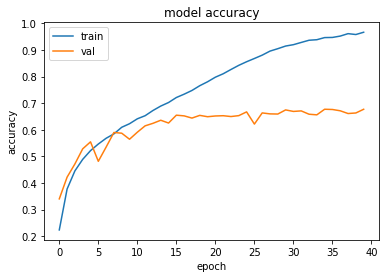

In [ ]:
## CIFAR10 transfer learning ##
## Training parameters ##
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
epochs = 40
batch_size=128

model_tf50.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model_tf50.fit(x_train,y_train,
                    epochs=epochs,
                    validation_data=(x_val,y_val))


# Evaluate Model on Test set
score = model_tf50.evaluate(x_test,
                       y_test,
                       batch_size=batch_size,
                       verbose=2)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))
model_tf50.save('best_tf_resnet50_model_c10.h5')

#Plot training curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#Cifar100
base_model_100 = ResNet50(include_top=False,weights='imagenet',input_shape=(256, 256, 3),classes=y_train_100.shape[1])

#Fine Tuning 
base_model_100.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model_100.layers))

# Fine-tune from this layer onwards
fine_tune_at = 75

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_100.layers[:fine_tune_at]:
  layer.trainable =  False

inputs = tf.keras.Input(shape=(32, 32, 3))
u =tf.keras.layers.UpSampling2D()(inputs)
u=tf.keras.layers.UpSampling2D()(u)
u=tf.keras.layers.UpSampling2D()(u)
x = base_model_100(u)
x = AveragePooling2D(pool_size=(7,7))(x)
y = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
y = Dense(512, activation='relu')(y)
outputs = Dense(num_labels_100,
                  activation='softmax',
                  kernel_initializer='he_normal')(y)
model_tf50_100 = Model(inputs, outputs)

model_tf50_100.summary()

    

Number of layers in the base model:  175
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d_54 (UpSampling (None, 64, 64, 3)         0         
_________________________________________________________________
up_sampling2d_55 (UpSampling (None, 128, 128, 3)       0         
_________________________________________________________________
up_sampling2d_56 (UpSampling (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
average_pooling2d_27 (Averag (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_23 (Flatt

Epoch 1/40
1407/1407 [==============================] - 124s 85ms/step - loss: 4.2931 - accuracy: 0.0692 - val_loss: 3.4452 - val_accuracy: 0.1930
Epoch 2/40
1407/1407 [==============================] - 119s 85ms/step - loss: 3.0230 - accuracy: 0.2682 - val_loss: 2.9368 - val_accuracy: 0.2760
Epoch 3/40
1407/1407 [==============================] - 119s 85ms/step - loss: 2.4253 - accuracy: 0.3879 - val_loss: 2.4203 - val_accuracy: 0.3846
Epoch 4/40
1407/1407 [==============================] - 119s 85ms/step - loss: 2.0284 - accuracy: 0.4761 - val_loss: 2.2970 - val_accuracy: 0.4042
Epoch 5/40
1407/1407 [==============================] - 119s 85ms/step - loss: 1.7084 - accuracy: 0.5526 - val_loss: 2.1420 - val_accuracy: 0.4396
Epoch 6/40
1407/1407 [==============================] - 119s 85ms/step - loss: 1.4645 - accuracy: 0.6158 - val_loss: 2.1414 - val_accuracy: 0.4544
Epoch 7/40
1407/1407 [==============================] - 119s 84ms/step - loss: 1.2134 - accuracy: 0.6816 - val_loss: 2

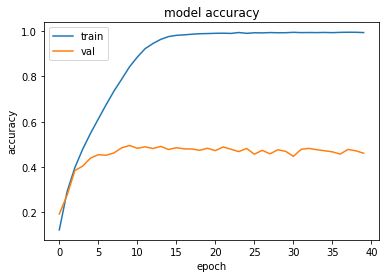

In [ ]:
## CIFAR100 transfer learning 
## Training parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
epochs = 40
batch_size=128

model_tf50_100.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model_tf50_100.fit(x_train_100,y_train_100,
                    epochs=epochs,
                    validation_data=(x_val_100,y_val_100))


# Evaluate Model on Test set
score = model_tf50_100.evaluate(x_test_100,
                       y_test_100,
                       batch_size=batch_size,
                       verbose=2)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))
model_tf50_100.save('best_tf_resnet50_model_c100.h5')

#Plot training curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()